In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
from baselines.common import set_global_seeds, tf_util as U
import gym
import roboschool
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
from base_line_model.TRPO_agent import TRPO_agent_new
from base_line_model.mlp import MlpPolicy_new
from baselines import logger

plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

Logging to /tmp/openai-2018-05-04-21-06-14-425930


In [2]:
class para_dummy(object):
    def __init__(self):
        self.timesteps_per_batch = 50000 # what to train on
        self.max_kl = 0.01
        self.cg_iters = 10
        self.gamma = 0.995
        self.lam =  0.97# advantage estimation
        self.entcoeff=0.0
        self.cg_damping=0.1
        self.vf_stepsize=1e-3
        self.vf_iters =5
        self.max_timesteps = 1e8
        self.max_episodes=0
        self.max_iters=0  # time constraint
        self.max_epi_avg = 1001
        self.callback=None
        

class env_dummy(object):
    def __init__(self,name):
        # parameter
        self.env = gym.make(name)
        self.ratio = 1
        self.threshold = np.array([ 0.13973436,  0.07678319,  0.00016729,  0.00786861,  0.02336518])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
        
def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=128, num_hid_layers=2)

In [3]:
class adversial_env(object):
    agn_index = 1
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.ratio = 0.7
        self.threshold = np.array([ 0.14244403,  0.07706523,  0.00016789,  0.00789366,  0.02395424])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
        
        par_dum = para_dummy()
        env_dum = env_dummy("RoboschoolInvertedPendulum-v1")
        self.adv_agn = TRPO_agent_new('pi1', env_dum, policy_fn, par_dum)
        self.adv_agn.restore('adversary')
        adversial_env.agn_index = adversial_env.agn_index+1
        
        
        
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r
        
        self.total_score += final_r
        
        # return noise output (adversarial)
        action = self.adv_agn.action_ev(self.obsr)
        obs = np.clip(action,-1,1)*self.threshold*self.ratio + self.obsr
        return obs, final_r, done, 0
        
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
    
    
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def env_reset(self):
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
    
    def result_plot(self):
        fon_size = 19
        x = list(range(0, len(self.score_list[1:])))
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.scatter(x,self.score_list[1:], s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('cumulative reward',fontsize=fon_size)
        plt.ylim([0,1200])
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        x = list(range(0, len(self.epi_list)))
        plt.scatter(x,self.epi_list, s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.ylim([0,1200])
        plt.show()

# Without observer when disturbance exist

In [4]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        obs, r, done, _ = env.step(obs)
        if done:
            do = True

        score += r

[2018-05-04 21:06:14,693] Making new env: RoboschoolInvertedPendulum-v1
[2018-05-04 21:06:14,698] Making new env: RoboschoolInvertedPendulum-v1


Init param sum 1.91204
INFO:tensorflow:Restoring parameters from adversary/data


[2018-05-04 21:06:15,990] Restoring parameters from adversary/data


499.0 [499.0] [500]


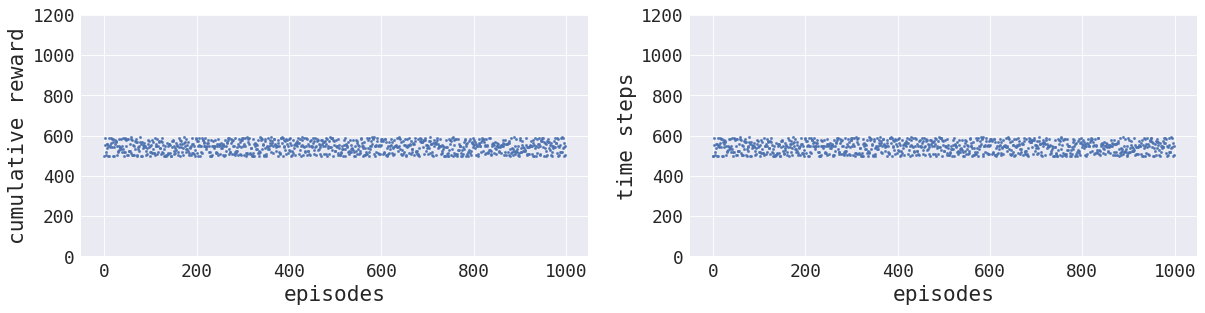

In [5]:
env.result_plot()

# define an observer (new agent)

In [6]:
env.env_reset()
class pargm(object):
    def __init__(self):
        self.timesteps_per_batch = 50000 # what to train on
        self.max_kl = 0.01
        self.cg_iters = 10
        self.gamma = 0.995
        self.lam =  0.97# advantage estimation
        self.entcoeff=0.0
        self.cg_damping=0.1
        self.vf_stepsize=1e-3
        self.vf_iters =5
        self.max_timesteps = 1e8
        self.max_episodes=0
        self.max_iters=0  # time constraint
        self.max_epi_avg = 1000
        self.callback=None

    
parg = pargm()
agn = TRPO_agent_new('pi2', env, policy_fn, parg)
#agn.load_model('agent_model/distr_observer')

Init param sum 22.8453


In [7]:
agn.learn()

********** Iteration 0 ************
sampling
21.0 [21.0] [22]
done in 88.382 seconds
computegrad
done in 0.185 seconds
cg
      iter residual norm  soln norm
         0      0.324          0
         1    0.00243     0.0391
         2    0.00188     0.0459
         3    0.00152     0.0823
         4    0.00033      0.142
         5   0.000217      0.144
         6   1.72e-05      0.149
         7   2.89e-06      0.154
         8   1.41e-05      0.154
         9   1.58e-05      0.154
        10   2.92e-07      0.155
done in 0.563 seconds
Expected: 0.023 Actual: 0.023
Stepsize OK!
vf
done in 11.246 seconds
--------------------------------
| EpLenMean       | 24.3       |
| EpRewMean       | 24.3       |
| EpThisIter      | 2199       |
| EpisodesSoFar   | 2199       |
| TimeElapsed     | 101        |
| TimestepsSoFar  | 49986      |
| entloss         | 0.0        |
| entropy         | 7.09393    |
| ev_tdlam_before | -0.00994   |
| meankl          | 0.00913602 |
| optimgain       | 0.023

         6   0.000506     0.0596
         7    3.4e-05     0.0738
         8   4.23e-05      0.076
         9   9.72e-06     0.0768
        10   9.85e-06     0.0784
done in 0.505 seconds
Expected: 0.012 Actual: 0.012
Stepsize OK!
vf
done in 11.046 seconds
--------------------------------
| EpLenMean       | 681        |
| EpRewMean       | 681        |
| EpThisIter      | 71         |
| EpisodesSoFar   | 6615       |
| TimeElapsed     | 773        |
| TimestepsSoFar  | 399936     |
| entloss         | 0.0        |
| entropy         | 7.09393    |
| ev_tdlam_before | 0.718      |
| meankl          | 0.00968456 |
| optimgain       | 0.012326   |
| surrgain        | 0.012326   |
--------------------------------
********** Iteration 8 ************
sampling
done in 83.717 seconds
computegrad
done in 0.160 seconds
cg
      iter residual norm  soln norm
         0    0.00233          0
         1    0.00148     0.0102
         2   0.000537     0.0247
         3   6.47e-05     0.0282
         

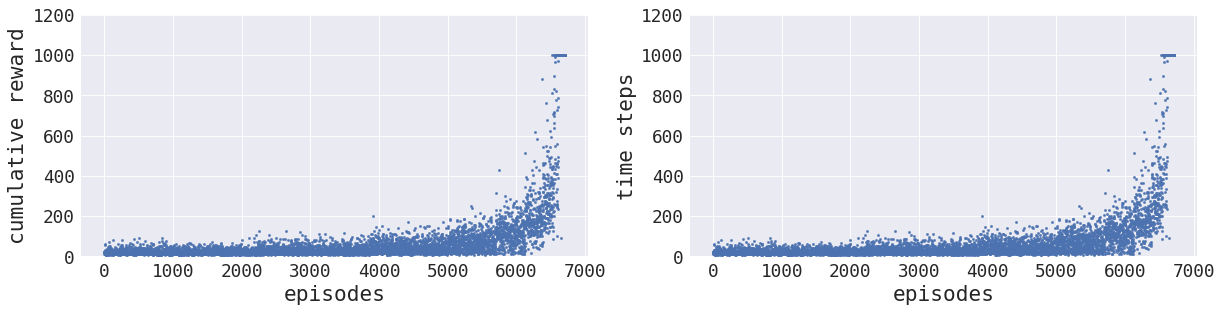

In [8]:
env.result_plot()

# Agent evaluation

In [9]:
env.env_reset()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.action_ev(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

999.0 [999.0] [1000]


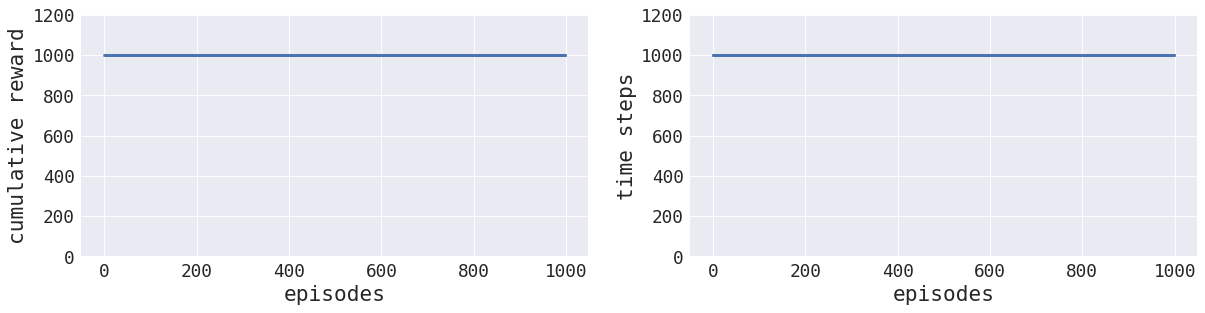

In [10]:
env.result_plot()

# Performance on non-adversarial

In [11]:
env.env_reset()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.action_ev(obs)
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

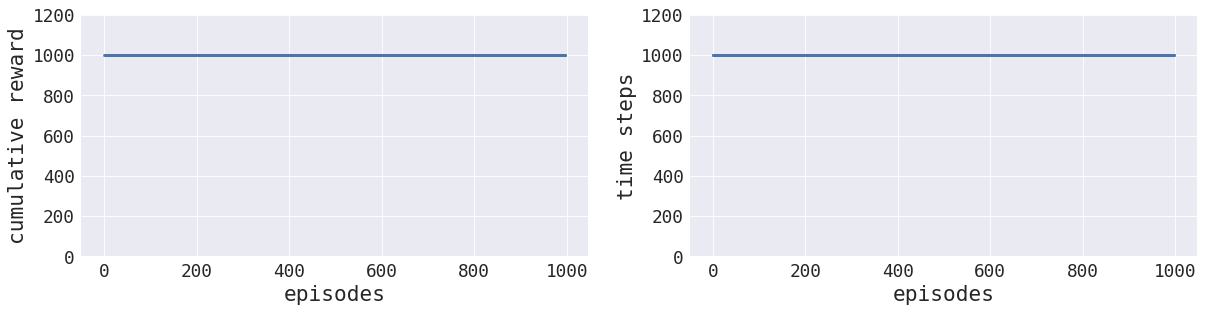

In [12]:
env.result_plot()

# Save model

In [15]:
agn.save_data('observer')